In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [18]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 30,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [5]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

## MNAR LR

### Local

2case {'s1': '8000', 's2': '2000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 08:53:30.904 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:53:30.905 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 08:54:27.248 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:54:27.249 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 08:55:28.536 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:55:28.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 08:56:29.968 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:56:29.969 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

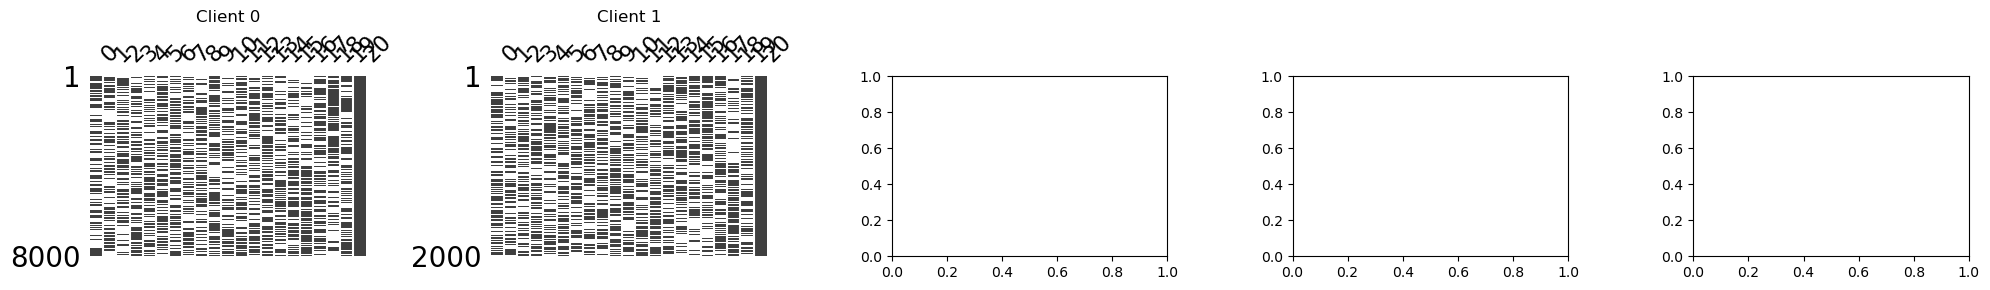

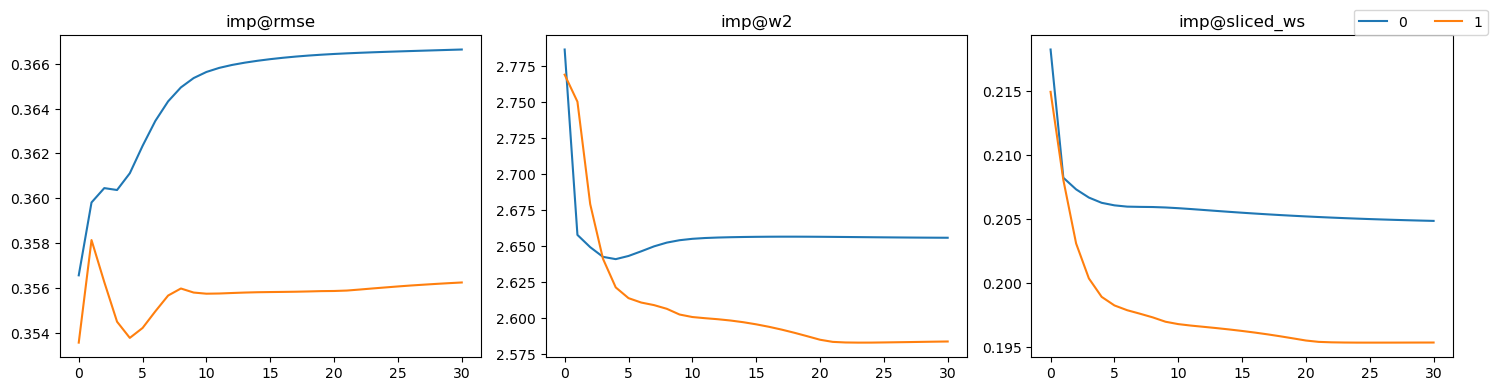

{'imp@rmse': 0.36139335326540084, 'imp@ws': 2.619590360807969, 'imp@sliced_ws': 0.2001088041259244}


In [46]:
config2 = experiment_config_template.copy()
strategy = 'local'
name = 'mnar_lr_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=8000@s2=2000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [47]:
pred_ret = NN_evaluation(
    rets['mnar_lr_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 08:56:37.636 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5089, train_loss: 0.6931 val_accu: 0.5040 val_f1: 0.4172
2023-07-23 08:56:58.104 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7132, train_loss: 0.6331 val_accu: 0.6110 val_f1: 0.6018
2023-07-23 08:57:19.218 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7044, train_loss: 0.6267 val_accu: 0.6200 val_f1: 0.6200
2023-07-23 08:57:40.986 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6667, train_loss: 0.6258 val_accu: 0.5985 val_f1: 0.5842
2023-07-23 08:58:03.871 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6893, train_loss: 0.6172 val_accu: 0.6155 val_f1: 0.6118


0.7359514976020269


In [61]:
pred_ret = NN_evaluation(
    rets['mnar_lr_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-23 09:26:19.866 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7268, test_f1: 0.7266, val_loss: 0.7005, val_accu: 0.5670, val_f1: 0.5666
2023-07-23 09:27:17.234 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6422, test_f1: 0.6396, val_loss: 0.6832, val_accu: 0.5960, val_f1: 0.5927
2023-07-23 09:28:15.434 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6133, test_f1: 0.6103, val_loss: 0.6938, val_accu: 0.5930, val_f1: 0.5902
2023-07-23 09:29:12.582 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6103, test_f1: 0.6084, val_loss: 0.7047, val_accu: 0.5910, val_f1: 0.5885
2023-07-23 09:30:08.705 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6199, test_f1: 0.619

0.7297982083069405


### Simple Average

2case {'s1': '8000', 's2': '2000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 08:58:40.797 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:58:40.798 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 08:59:36.214 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 08:59:36.215 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 09:00:38.356 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:00:38.357 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 09:01:40.575 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:01:40.576 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

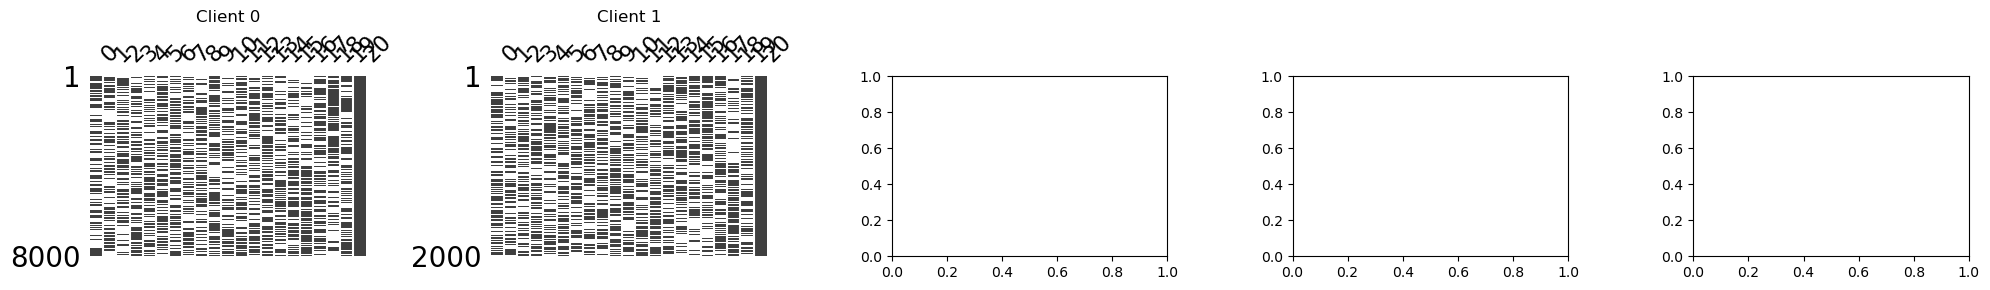

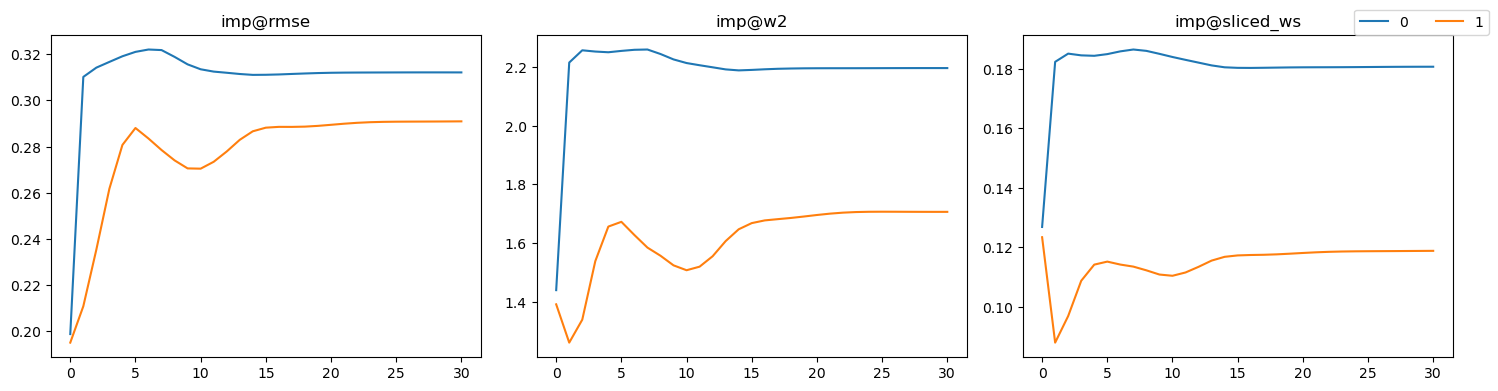

{'imp@rmse': 0.3015025042594913, 'imp@ws': 1.951900712775069, 'imp@sliced_ws': 0.14968562507797725}


In [48]:
config2 = experiment_config_template.copy()
strategy = 'fedavg-s'
name = 'mnar_lr_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=8000@s2=2000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [49]:
pred_ret = NN_evaluation(
    rets['mnar_lr_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-23 09:01:48.336 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5106, train_loss: 0.6932 val_accu: 0.5075 val_f1: 0.4194
2023-07-23 09:02:09.318 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.6427, train_loss: 0.5735 val_accu: 0.7095 val_f1: 0.7093
2023-07-23 09:02:31.217 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6099, train_loss: 0.5425 val_accu: 0.7130 val_f1: 0.7107
2023-07-23 09:02:53.248 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.5961, train_loss: 0.5372 val_accu: 0.7055 val_f1: 0.7007
2023-07-23 09:03:15.215 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.5894, train_loss: 0.5210 val_accu: 0.7460 val_f1: 0.7459


0.7184870147497964


In [62]:
pred_ret = NN_evaluation(
    rets['mnar_lr_fedavg-s'], type='fedavg', n_rounds=500, server_config_tmpl=server_config_tmpl
)

2023-07-23 09:35:47.203 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6683, test_f1: 0.6658, val_loss: 0.6861, val_accu: 0.6620, val_f1: 0.6611
2023-07-23 09:36:42.132 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6142, test_f1: 0.5925, val_loss: 0.6547, val_accu: 0.6865, val_f1: 0.6839
2023-07-23 09:37:39.064 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6380, test_f1: 0.6378, val_loss: 0.6198, val_accu: 0.7155, val_f1: 0.7155
2023-07-23 09:38:36.443 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5894, test_f1: 0.5613, val_loss: 0.6191, val_accu: 0.7110, val_f1: 0.7109
2023-07-23 09:39:33.092 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5940, test_f1: 0.565

0.7059994570627093


### Our

2case {'s1': '8000', 's2': '2000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 09:03:51.977 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:03:51.977 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 09:04:46.947 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:04:46.948 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 09:05:47.681 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:05:47.682 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 09:06:49.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:06:49.104 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

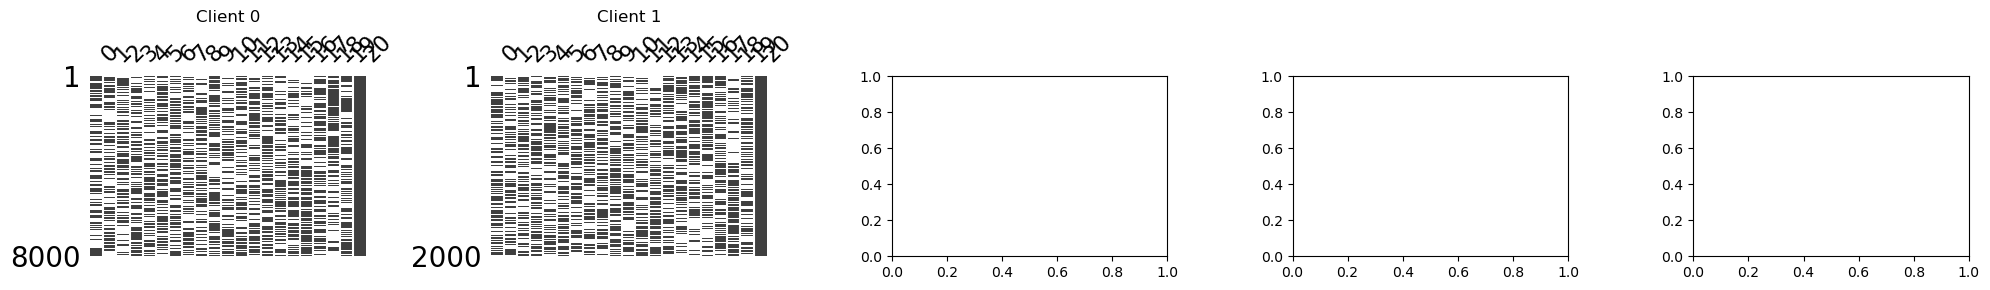

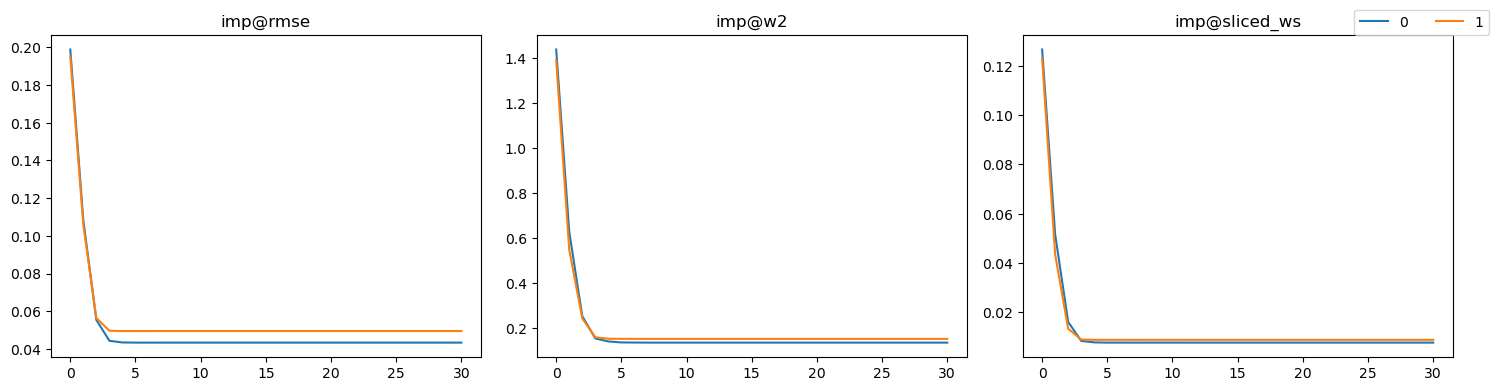

{'imp@rmse': 0.046450811633907935, 'imp@ws': 0.14301476946648348, 'imp@sliced_ws': 0.008026652699917487}


In [50]:
config2 = experiment_config_template.copy()
strategy = 'fedmechw'
name = 'mnar_lr_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=8000@s2=2000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [51]:
pred_ret = NN_evaluation(
    rets['mnar_lr_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 09:06:56.671 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5238, train_loss: 0.6918 val_accu: 0.5235 val_f1: 0.3981
2023-07-23 09:07:16.944 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.9101, train_loss: 0.3600 val_accu: 0.8640 val_f1: 0.8638
2023-07-23 09:07:38.243 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.9183, train_loss: 0.3284 val_accu: 0.8640 val_f1: 0.8640
2023-07-23 09:08:00.234 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9192, train_loss: 0.3278 val_accu: 0.8775 val_f1: 0.8773
2023-07-23 09:08:21.976 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9230, train_loss: 0.3050 val_accu: 0.8800 val_f1: 0.8799


0.9271559134919917


In [63]:
pred_ret = NN_evaluation(
    rets['mnar_lr_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 09:44:10.505 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9034, test_f1: 0.9030, val_loss: 0.3489, val_accu: 0.8570, val_f1: 0.8559
2023-07-23 09:45:05.945 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9176, test_f1: 0.9174, val_loss: 0.3209, val_accu: 0.8700, val_f1: 0.8692
2023-07-23 09:46:00.495 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9256, test_f1: 0.9255, val_loss: 0.3061, val_accu: 0.8805, val_f1: 0.8800
2023-07-23 09:46:54.434 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9311, test_f1: 0.9311, val_loss: 0.2944, val_accu: 0.8835, val_f1: 0.8832
2023-07-23 09:47:46.249 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9329, test_f1: 0.932

0.9379241697583929


## MNAR LR Equal

### Local

2case {'s1': '5000', 's2': '5000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 09:11:35.655 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:11:35.656 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 09:12:08.973 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:12:08.975 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 09:12:45.596 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:12:45.597 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 09:13:22.554 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:13:22.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

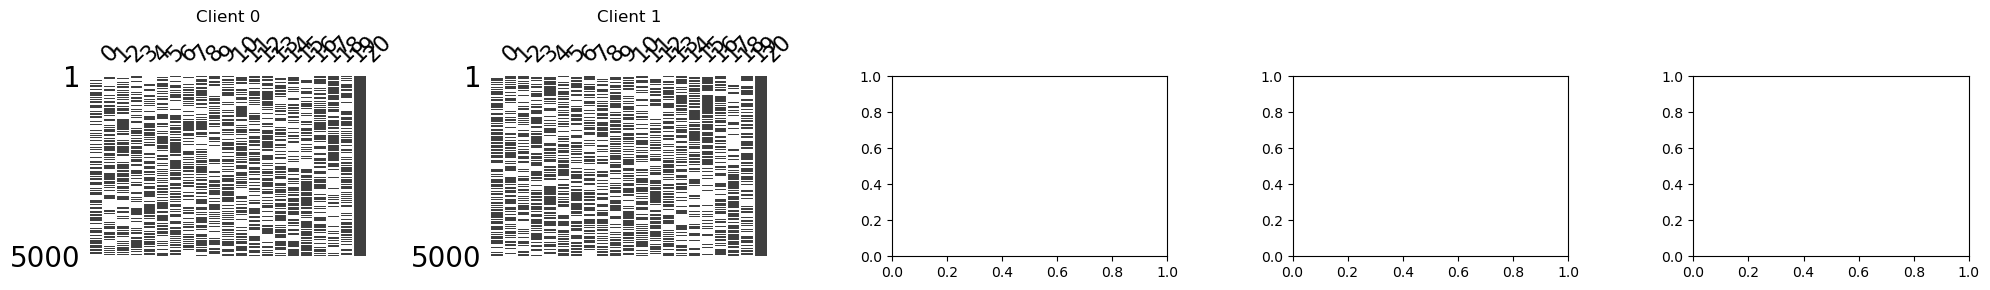

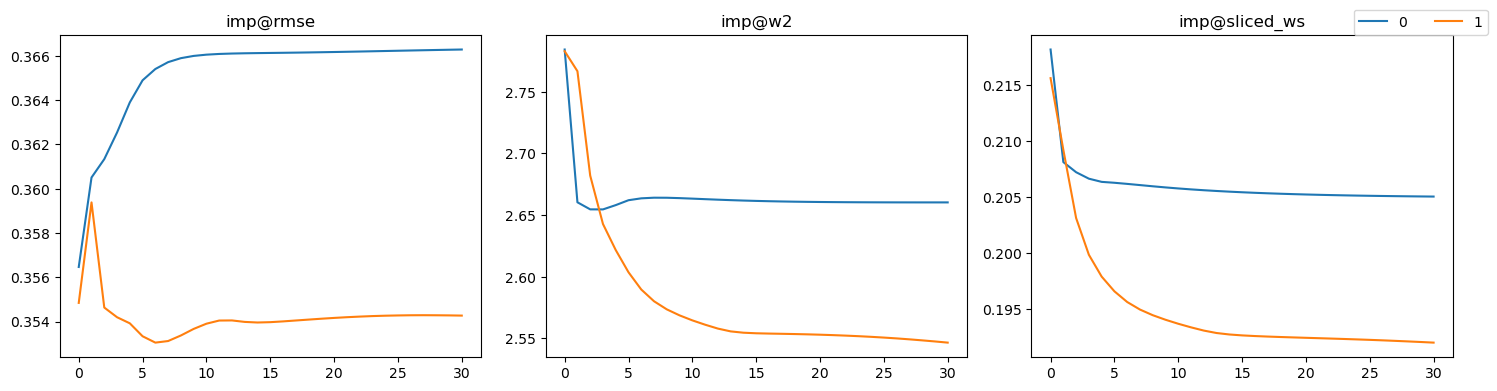

{'imp@rmse': 0.36026773622857505, 'imp@ws': 2.6043357850313487, 'imp@sliced_ws': 0.19858664034225593}


In [54]:
config2 = experiment_config_template.copy()
strategy = 'local'
name = 'mnar_lr2_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=5000@s2=5000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(
    rets['mnar_lr2_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 09:13:27.686 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5002, train_loss: 0.6935 val_accu: 0.5000 val_f1: 0.3333
2023-07-23 09:13:47.695 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7217, train_loss: 0.6319 val_accu: 0.6130 val_f1: 0.6130
2023-07-23 09:14:09.723 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7141, train_loss: 0.6245 val_accu: 0.6260 val_f1: 0.6260
2023-07-23 09:14:31.854 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6881, train_loss: 0.6153 val_accu: 0.6355 val_f1: 0.6319
2023-07-23 09:14:53.709 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6651, train_loss: 0.6135 val_accu: 0.6380 val_f1: 0.6339


0.7522396163243146


### Simple Average

2case {'s1': '5000', 's2': '5000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 09:15:30.038 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:15:30.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 09:16:03.831 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:16:03.832 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 09:16:41.284 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:16:41.285 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 09:17:18.638 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:17:18.639 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

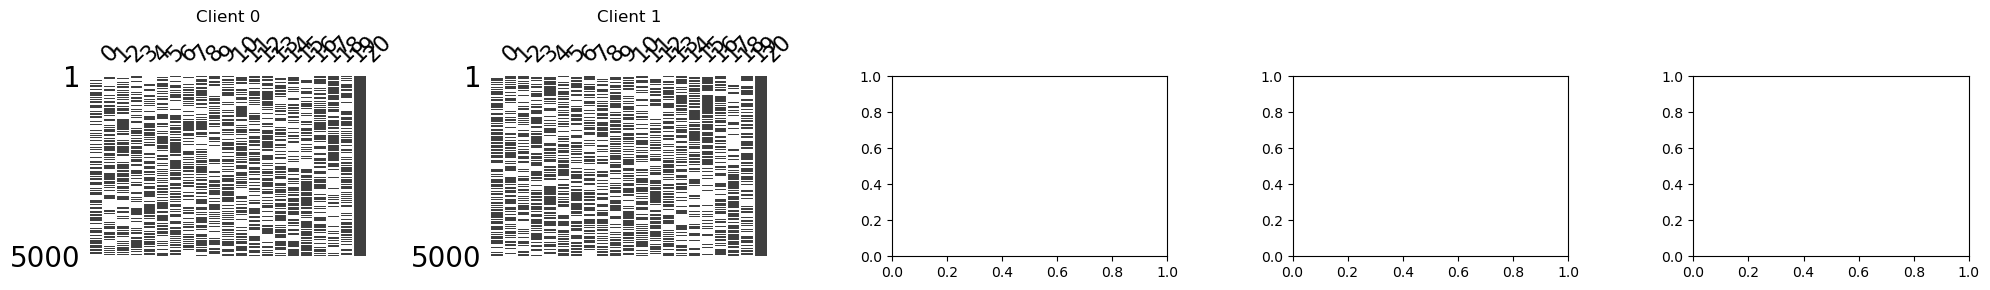

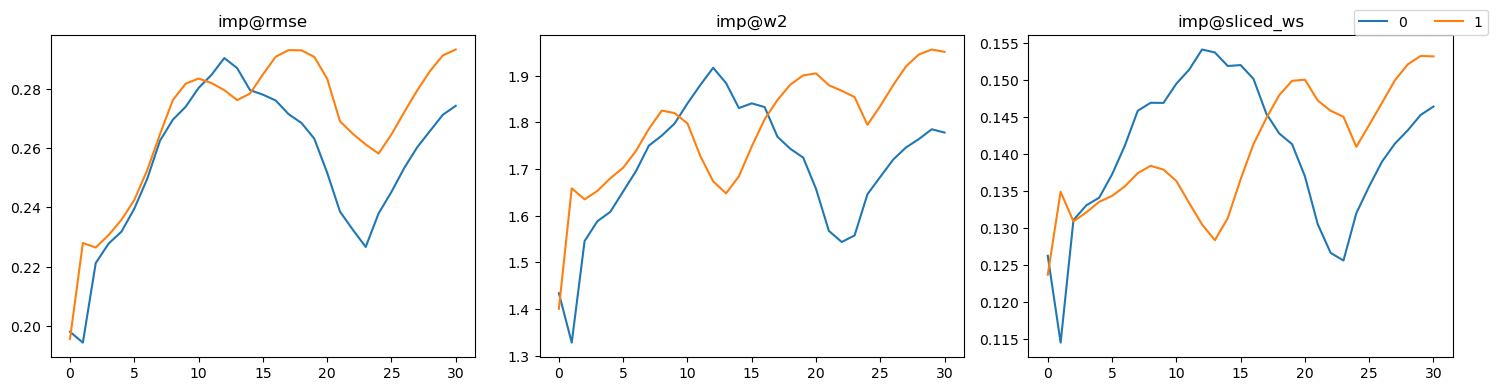

{'imp@rmse': 0.27464615673031295, 'imp@ws': 1.8449346611217514, 'imp@sliced_ws': 0.14703331712652726}


In [56]:
config2 = experiment_config_template.copy()
strategy = 'fedavg-s'
name = 'mnar_lr2_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=5000@s2=5000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [58]:
pred_ret = NN_evaluation(
    rets['mnar_lr2_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 09:17:55.967 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5318, train_loss: 0.6934 val_accu: 0.4980 val_f1: 0.3461
2023-07-23 09:18:16.810 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7864, train_loss: 0.5507 val_accu: 0.6985 val_f1: 0.6982
2023-07-23 09:18:38.722 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7580, train_loss: 0.5353 val_accu: 0.7155 val_f1: 0.7099
2023-07-23 09:19:00.630 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7221, train_loss: 0.5183 val_accu: 0.7255 val_f1: 0.7252
2023-07-23 09:19:22.193 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7031, train_loss: 0.5089 val_accu: 0.7290 val_f1: 0.7285


0.7901547371278618


### Our Models

2case {'s1': '5000', 's2': '5000'}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-23 09:19:58.804 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:19:58.805 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 09:20:32.858 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:20:32.859 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 09:21:10.364 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:21:10.365 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 09:21:48.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 09:21:48.164 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

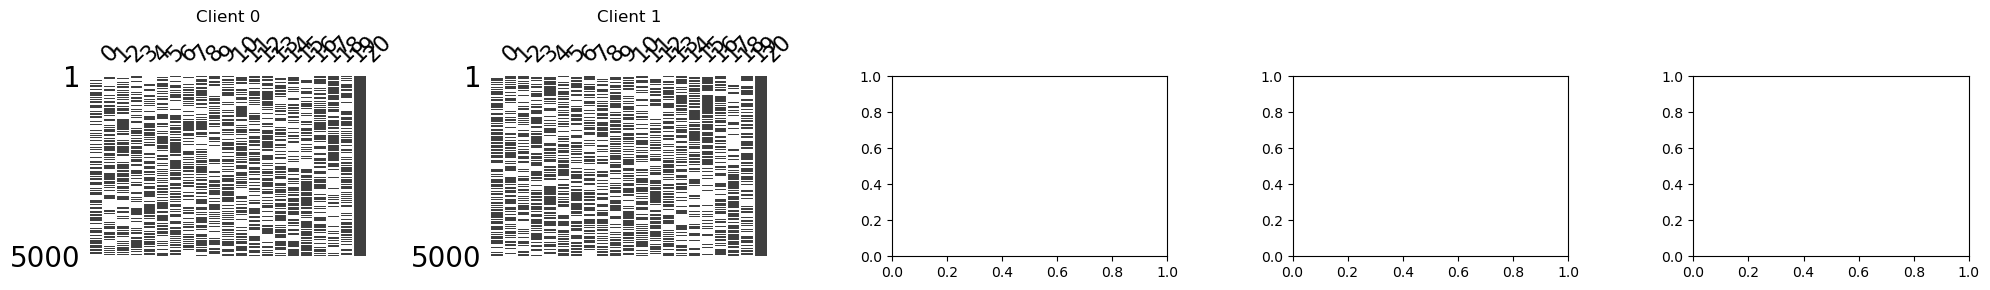

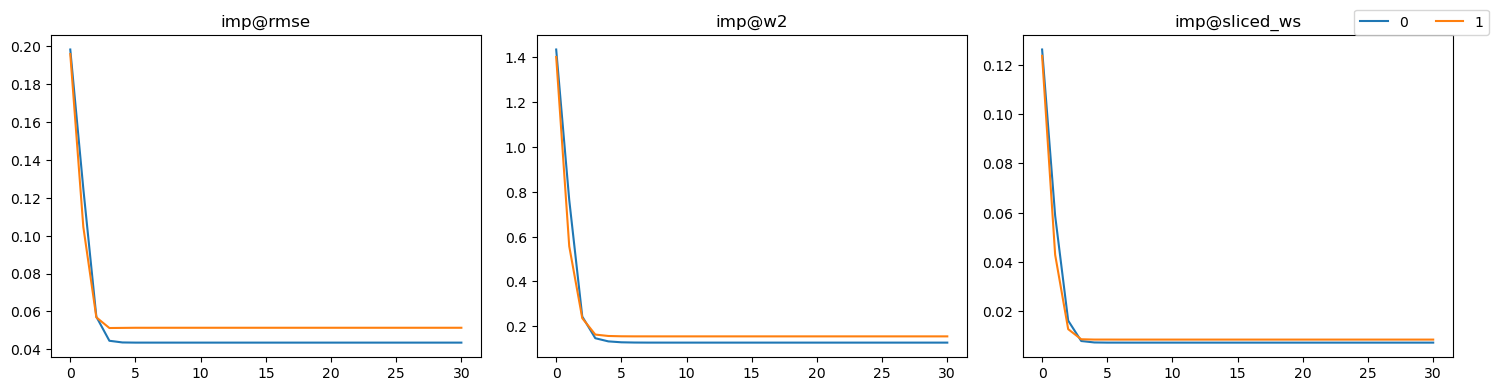

{'imp@rmse': 0.04748352175901078, 'imp@ws': 0.14126367848250146, 'imp@sliced_ws': 0.007930989941727015}


In [59]:
config2 = experiment_config_template.copy()
strategy = 'fedmechw'
name = 'mnar_lr2_{}'.format(strategy)
config2['agg_strategy_imp']['strategy'] = strategy
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 2
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=even'
config2['data_partition']['strategy'] = '2case@s1=5000@s2=5000'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [60]:
pred_ret = NN_evaluation(
    rets['mnar_lr2_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 09:21:53.521 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.6327, train_loss: 0.6919 val_accu: 0.5965 val_f1: 0.5913
2023-07-23 09:22:13.692 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.9037, train_loss: 0.3701 val_accu: 0.8455 val_f1: 0.8453
2023-07-23 09:22:35.263 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.9037, train_loss: 0.3564 val_accu: 0.8365 val_f1: 0.8364
2023-07-23 09:22:57.065 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9100, train_loss: 0.3489 val_accu: 0.8445 val_f1: 0.8445
2023-07-23 09:23:19.698 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9084, train_loss: 0.3383 val_accu: 0.8580 val_f1: 0.8576


0.922088498778391


In [64]:
rets.keys()

dict_keys(['mnar_lr_local', 'mnar_lr_fedavg-s', 'mnar_lr_fedmechw', 'mnar_lr2_local', 'mnar_lr2_fedavg-s', 'mnar_lr2_fedmechw'])

## MARY LR 1:2

### Local 

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 22:58:31.483 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:58:31.484 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 22:59:16.845 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:59:16.846 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:00:01.890 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:00:01.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:00:47.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:00:47.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

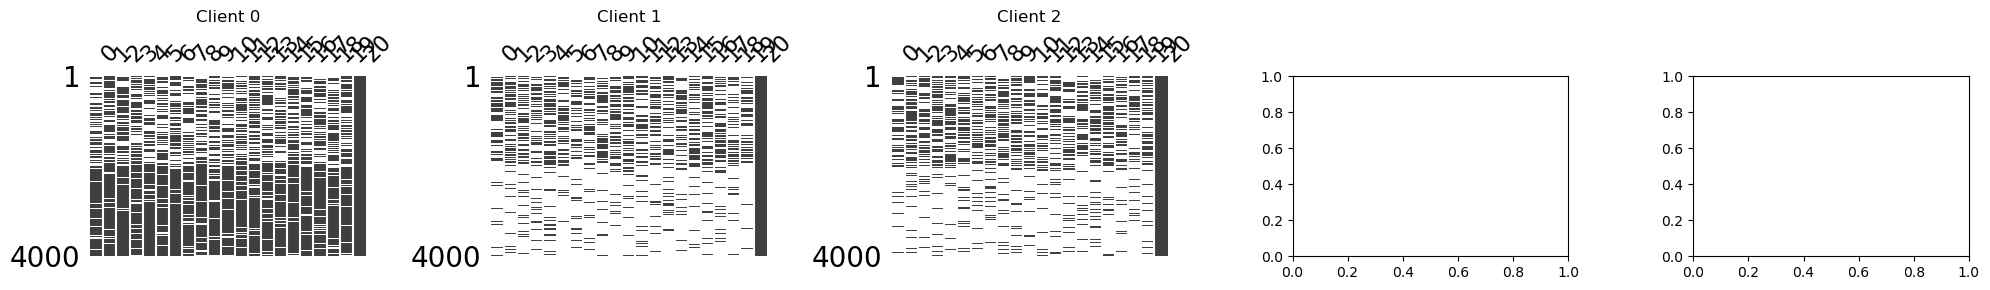

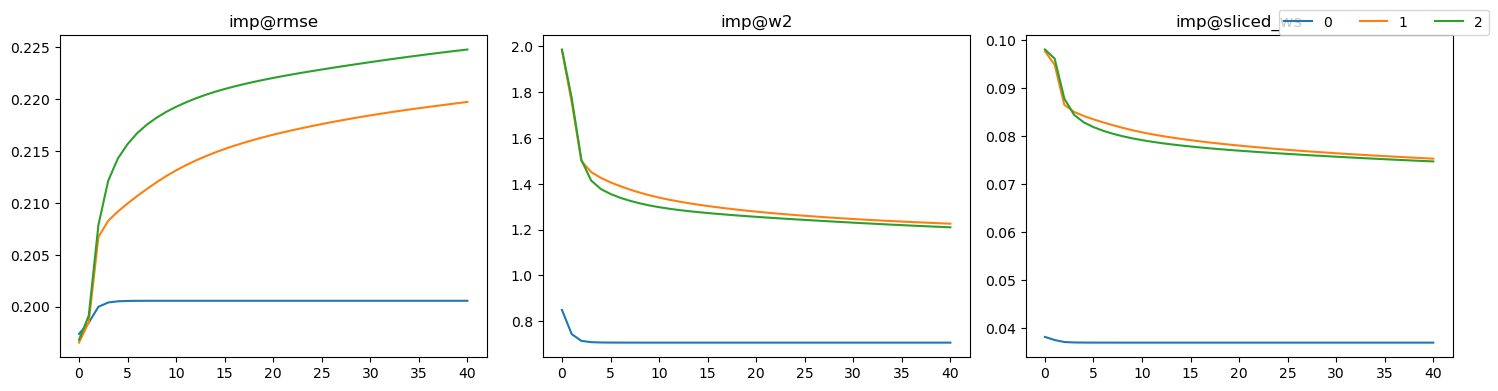

{'imp@rmse': 0.21483419636511594, 'imp@ws': 1.04982205447191, 'imp@sliced_ws': 0.06235744940589962}


In [24]:
name = 'mary_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [25]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:02:42.800 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7438, test_f1: 0.7388, val_loss: 0.7963, val_accu: 0.6212, val_f1: 0.5743
2023-07-22 23:03:45.959 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7685, test_f1: 0.7669, val_loss: 0.7857, val_accu: 0.6329, val_f1: 0.5935
2023-07-22 23:04:48.004 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7809, test_f1: 0.7808, val_loss: 0.7449, val_accu: 0.6512, val_f1: 0.6215
2023-07-22 23:05:55.534 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7934, test_f1: 0.7934, val_loss: 0.7278, val_accu: 0.6562, val_f1: 0.6291
2023-07-22 23:07:03.181 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7995, test_f1: 0.799

0.8006515247488915


In [26]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:12:18.972 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5008, train_loss: 0.6902 val_accu: 0.6088 val_f1: 0.5494
2023-07-22 23:12:43.470 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8169, train_loss: 0.4297 val_accu: 0.7887 val_f1: 0.7886
2023-07-22 23:13:07.503 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8175, train_loss: 0.4066 val_accu: 0.8021 val_f1: 0.8017
2023-07-22 23:13:31.248 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8016, train_loss: 0.3886 val_accu: 0.8071 val_f1: 0.8070
2023-07-22 23:13:55.133 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8054, train_loss: 0.3836 val_accu: 0.8108 val_f1: 0.8108


0.8486109854311827


### Simple Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:14:34.806 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:14:34.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:15:21.950 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:15:21.951 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:16:09.063 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:16:09.065 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:16:55.561 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:16:55.561 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

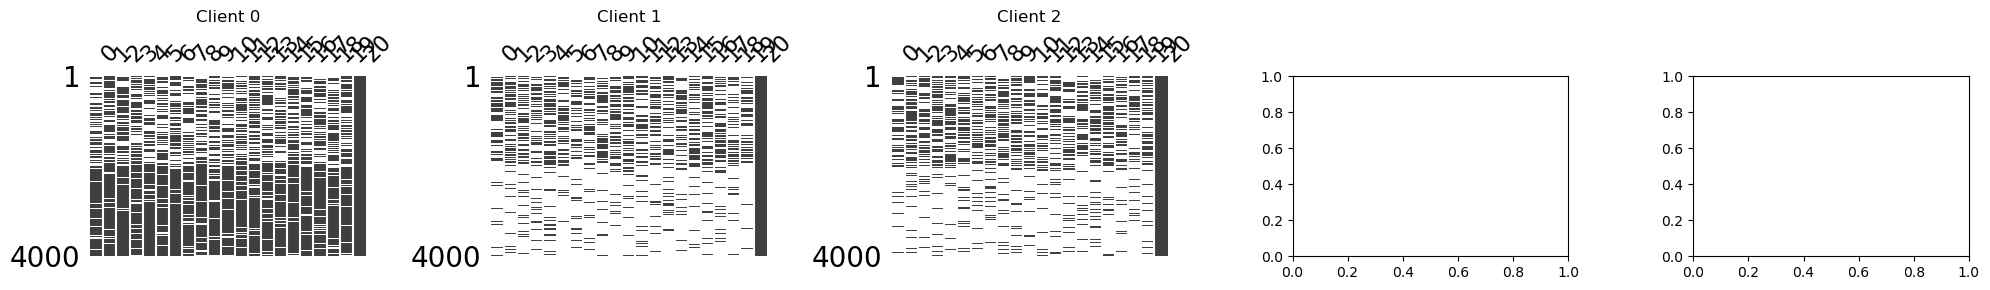

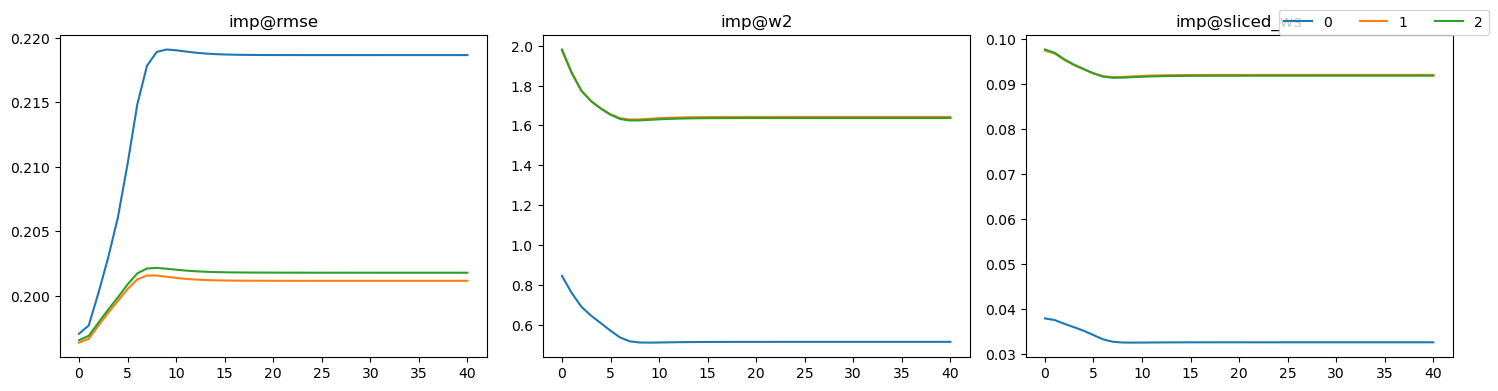

{'imp@rmse': 0.20721564465922732, 'imp@ws': 1.2645056524050304, 'imp@sliced_ws': 0.07217297816631461}


In [27]:
name = 'mary_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [28]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:18:51.603 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7534, test_f1: 0.7532, val_loss: 0.6835, val_accu: 0.6421, val_f1: 0.6150
2023-07-22 23:19:55.091 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7654, test_f1: 0.7653, val_loss: 0.6663, val_accu: 0.6621, val_f1: 0.6417
2023-07-22 23:20:57.308 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7648, test_f1: 0.7648, val_loss: 0.6527, val_accu: 0.6700, val_f1: 0.6536
2023-07-22 23:21:58.858 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7712, test_f1: 0.7712, val_loss: 0.6485, val_accu: 0.6742, val_f1: 0.6589
2023-07-22 23:23:02.266 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7638, test_f1: 0.763

0.7733236811148312


In [42]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:31:41.623 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5000, train_loss: 0.6917 val_accu: 0.4992 val_f1: 0.3381
2023-07-23 00:32:05.389 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8202, train_loss: 0.4140 val_accu: 0.8200 val_f1: 0.8200
2023-07-23 00:32:28.806 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7826, train_loss: 0.3924 val_accu: 0.7746 val_f1: 0.7684
2023-07-23 00:32:52.618 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8140, train_loss: 0.3705 val_accu: 0.8308 val_f1: 0.8304
2023-07-23 00:33:16.051 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8204, train_loss: 0.3605 val_accu: 0.8479 val_f1: 0.8479


0.8468011944620396


### Our Method

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:30:41.195 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:30:41.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:31:27.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:31:27.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:32:13.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:32:13.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:32:57.501 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:32:57.501 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

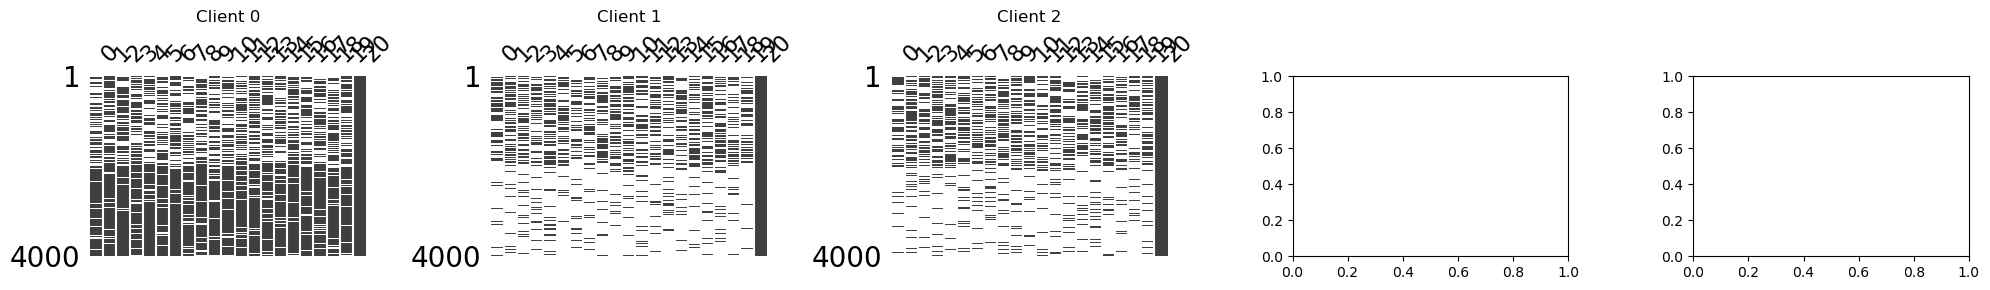

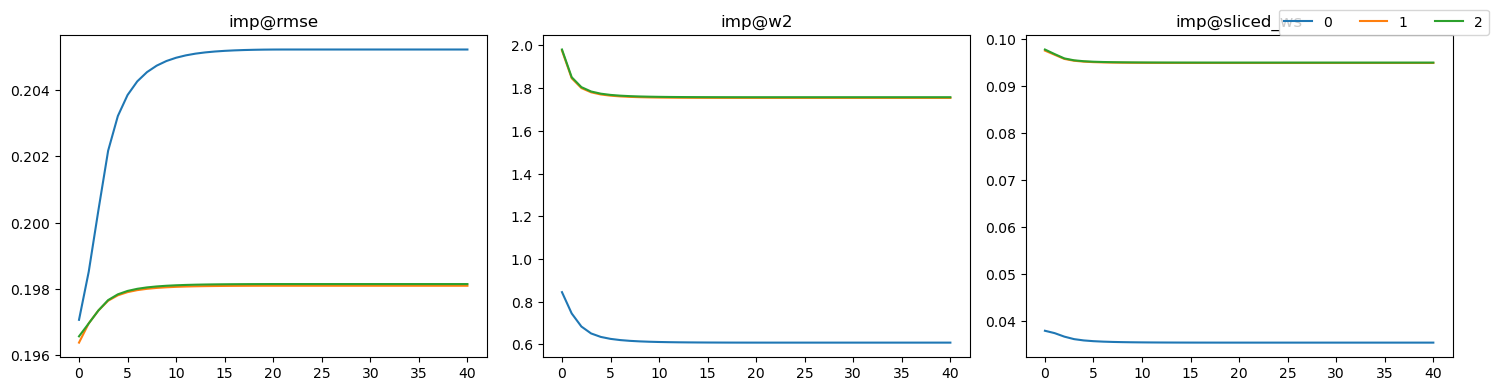

{'imp@rmse': 0.20049003694702353, 'imp@ws': 1.3734046821757693, 'imp@sliced_ws': 0.07504387302058735}


In [30]:
name = 'mary_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [31]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:34:54.138 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7712, test_f1: 0.7667, val_loss: 0.5621, val_accu: 0.7371, val_f1: 0.7335
2023-07-22 23:35:58.984 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7627, test_f1: 0.7560, val_loss: 0.5652, val_accu: 0.7342, val_f1: 0.7313
2023-07-22 23:37:04.118 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7484, test_f1: 0.7390, val_loss: 0.5565, val_accu: 0.7467, val_f1: 0.7450
2023-07-22 23:38:09.053 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7353, test_f1: 0.7236, val_loss: 0.5404, val_accu: 0.7504, val_f1: 0.7496
2023-07-22 23:39:17.577 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7267, test_f1: 0.712

0.7963080264229482


In [32]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:43:54.368 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5035, train_loss: 0.6921 val_accu: 0.5112 val_f1: 0.3717
2023-07-22 23:44:17.116 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8696, train_loss: 0.3773 val_accu: 0.8417 val_f1: 0.8417
2023-07-22 23:44:42.146 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7855, train_loss: 0.3525 val_accu: 0.8208 val_f1: 0.8186
2023-07-22 23:45:07.204 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8344, train_loss: 0.3382 val_accu: 0.8492 val_f1: 0.8491
2023-07-22 23:45:32.293 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8435, train_loss: 0.3284 val_accu: 0.8550 val_f1: 0.8550


0.8803728169396434


## MARY LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:46:12.934 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:46:12.935 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:46:57.988 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:46:57.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:47:41.969 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:47:41.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:48:25.881 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:48:25.882 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

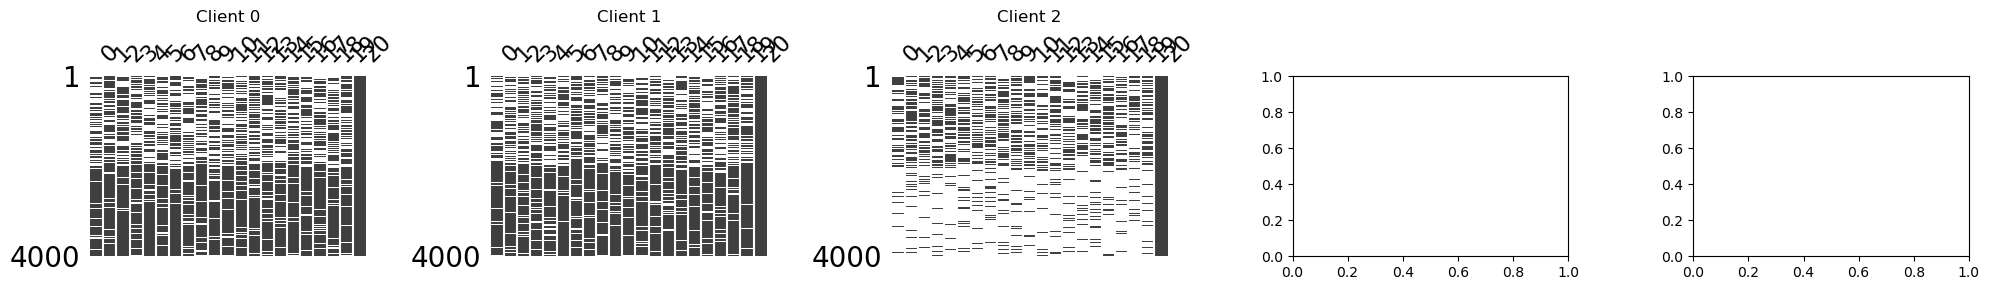

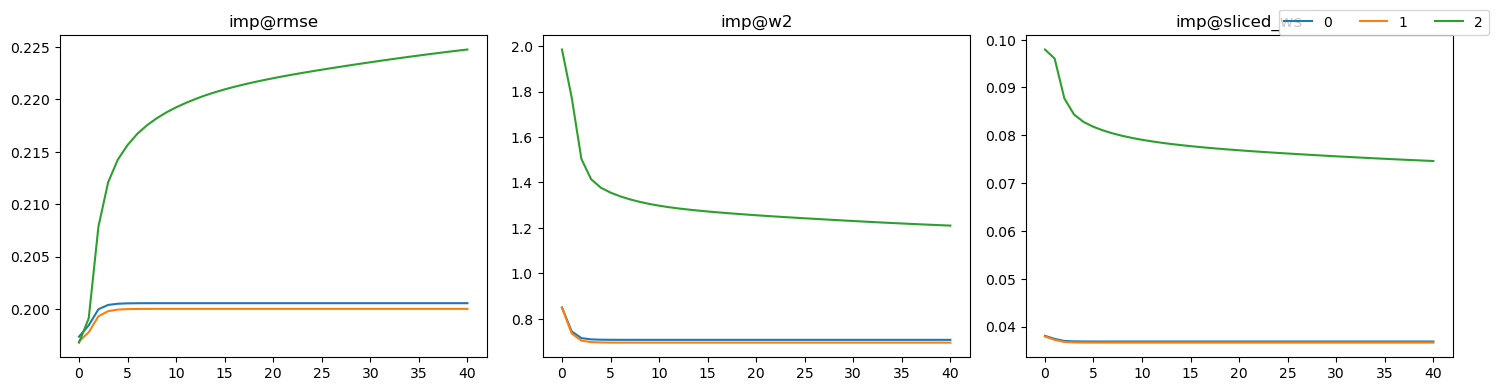

{'imp@rmse': 0.20835748576934607, 'imp@ws': 0.8716385543890449, 'imp@sliced_ws': 0.04943717574655493}


In [33]:
name = 'mary_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [34]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:50:22.903 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8217, test_f1: 0.8189, val_loss: 0.8710, val_accu: 0.7121, val_f1: 0.7029
2023-07-22 23:51:31.205 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7655, test_f1: 0.7550, val_loss: 0.8615, val_accu: 0.7221, val_f1: 0.7156
2023-07-22 23:52:39.290 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7524, test_f1: 0.7399, val_loss: 0.9160, val_accu: 0.7242, val_f1: 0.7188
2023-07-22 23:53:44.126 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7102, test_f1: 0.6864, val_loss: 0.9177, val_accu: 0.7200, val_f1: 0.7169
2023-07-22 23:54:49.490 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6896, test_f1: 0.658

0.8240883177992941


In [35]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:59:12.078 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5056, train_loss: 0.6930 val_accu: 0.5033 val_f1: 0.3901
2023-07-22 23:59:35.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7268, train_loss: 0.4917 val_accu: 0.7675 val_f1: 0.7675
2023-07-22 23:59:58.385 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6513, train_loss: 0.4607 val_accu: 0.7750 val_f1: 0.7738
2023-07-23 00:00:21.690 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6177, train_loss: 0.4361 val_accu: 0.7646 val_f1: 0.7613
2023-07-23 00:00:45.496 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6478, train_loss: 0.4113 val_accu: 0.8100 val_f1: 0.8099


0.8056284499140349


### Simpel Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-23 00:01:24.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:01:24.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 00:02:09.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:02:09.252 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 00:02:53.558 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:02:53.559 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 00:03:37.209 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:03:37.210 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

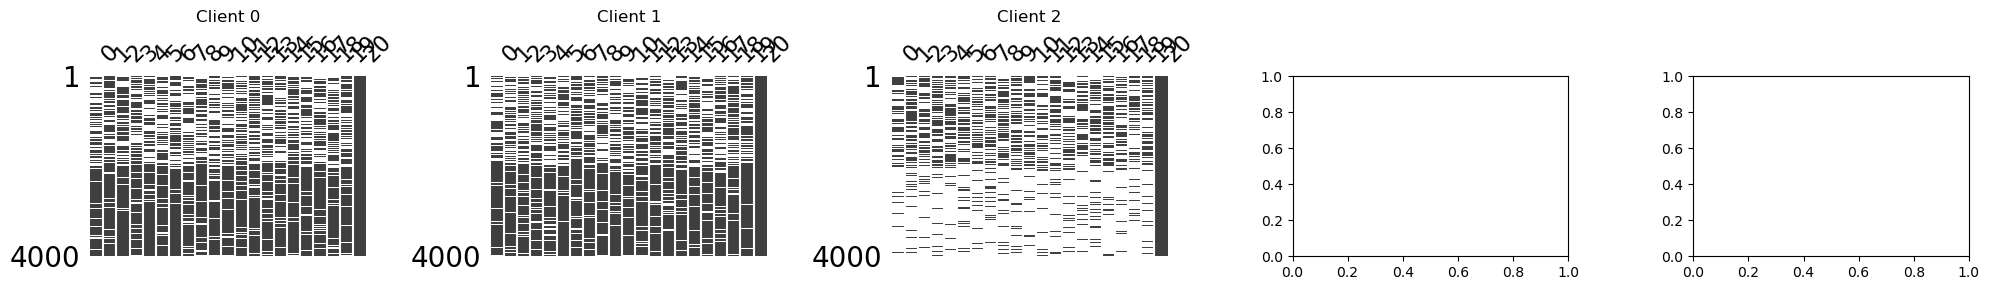

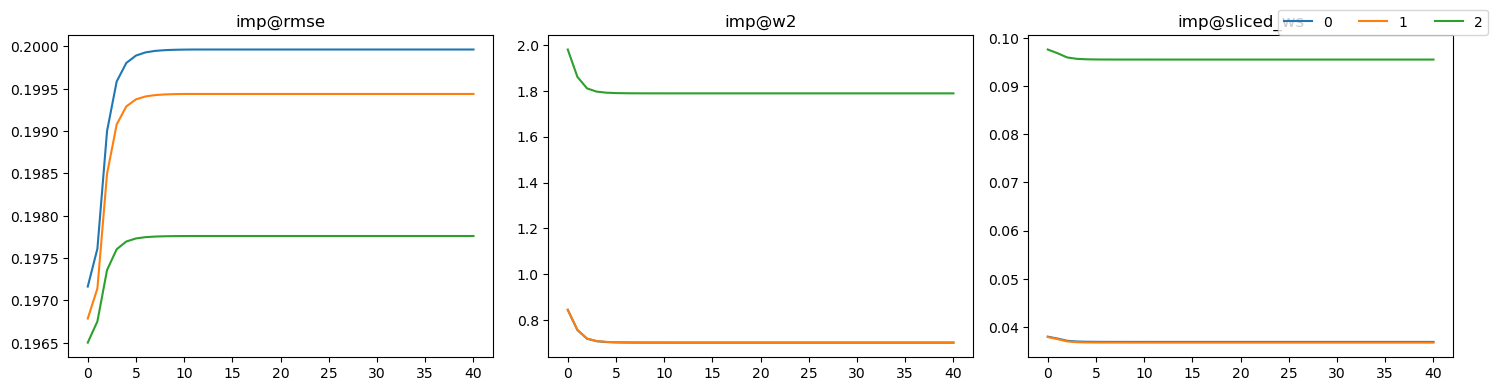

{'imp@rmse': 0.19905443089554506, 'imp@ws': 1.065175062213047, 'imp@sliced_ws': 0.05636542173626157}


In [36]:
name = 'mary_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [37]:
pred_ret = NN_evaluation(
    rets['mary_lr21_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:05:31.093 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8429, test_f1: 0.8427, val_loss: 0.8051, val_accu: 0.7117, val_f1: 0.6956
2023-07-23 00:06:35.263 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8576, test_f1: 0.8564, val_loss: 0.8391, val_accu: 0.7254, val_f1: 0.7117
2023-07-23 00:07:39.368 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8280, test_f1: 0.8251, val_loss: 0.8700, val_accu: 0.7292, val_f1: 0.7160
2023-07-23 00:08:43.393 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8235, test_f1: 0.8203, val_loss: 0.9095, val_accu: 0.7292, val_f1: 0.7153
2023-07-23 00:09:48.121 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8112, test_f1: 0.806

0.8624558863451272


In [38]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:14:21.039 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5056, train_loss: 0.6930 val_accu: 0.5033 val_f1: 0.3901
2023-07-23 00:14:45.340 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7268, train_loss: 0.4917 val_accu: 0.7675 val_f1: 0.7675
2023-07-23 00:15:10.084 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6513, train_loss: 0.4607 val_accu: 0.7750 val_f1: 0.7738
2023-07-23 00:15:34.814 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6177, train_loss: 0.4361 val_accu: 0.7646 val_f1: 0.7613
2023-07-23 00:15:59.637 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6478, train_loss: 0.4113 val_accu: 0.8100 val_f1: 0.8099


0.8056284499140349


### Ours

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-23 00:16:39.806 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:16:39.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 00:17:27.521 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:17:27.521 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 00:18:13.732 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:18:13.733 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 00:19:01.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:19:01.166 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

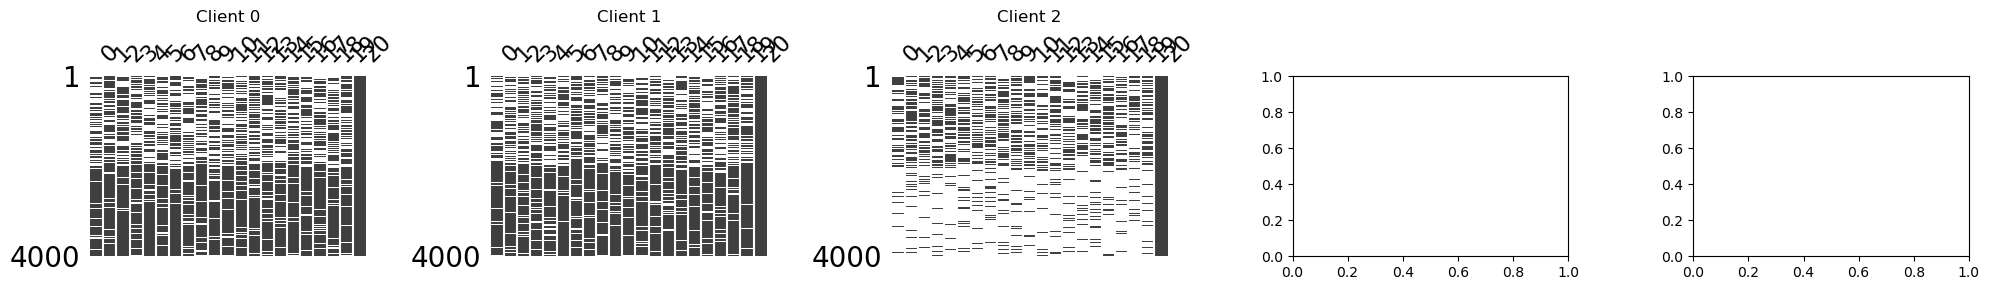

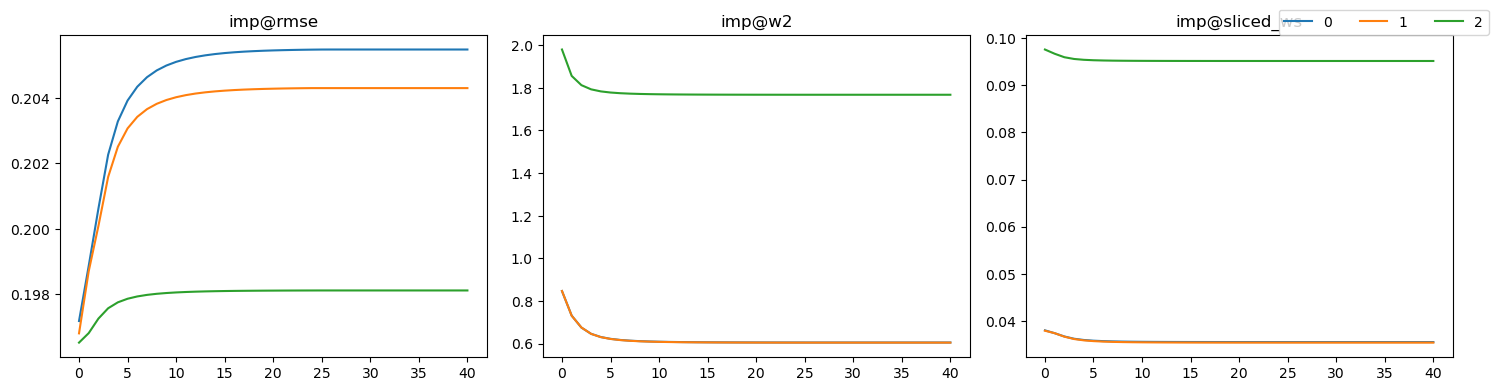

{'imp@rmse': 0.20263661509755337, 'imp@ws': 0.9918359308182967, 'imp@sliced_ws': 0.05532240804356454}


In [39]:
name = 'mary_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [40]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:20:56.858 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8242, test_f1: 0.8230, val_loss: 0.6226, val_accu: 0.7308, val_f1: 0.7170
2023-07-23 00:22:01.419 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8242, test_f1: 0.8221, val_loss: 0.6411, val_accu: 0.7312, val_f1: 0.7163
2023-07-23 00:23:06.113 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8038, test_f1: 0.7999, val_loss: 0.6507, val_accu: 0.7350, val_f1: 0.7206
2023-07-23 00:24:10.816 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7952, test_f1: 0.7899, val_loss: 0.6787, val_accu: 0.7375, val_f1: 0.7233
2023-07-23 00:25:15.919 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7884, test_f1: 0.782

0.8355804904533526


In [41]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:29:40.321 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5327, train_loss: 0.6923 val_accu: 0.5312 val_f1: 0.4507
2023-07-23 00:30:05.438 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7684, train_loss: 0.3718 val_accu: 0.8512 val_f1: 0.8508
2023-07-23 00:30:28.947 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6940, train_loss: 0.3343 val_accu: 0.8333 val_f1: 0.8306
2023-07-23 00:30:52.657 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7123, train_loss: 0.3143 val_accu: 0.8746 val_f1: 0.8744
2023-07-23 00:31:16.354 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7240, train_loss: 0.2972 val_accu: 0.8812 val_f1: 0.8812


0.8468011944620396
